# Learning neural networks within Jupyter Notebook

Are artificial neural networks hard, only for a handful of people possessing some forbidden knowledge?
Well, either there aren't, or it is possible to learn some of these hidden secrets in 45 min!

I will show you that, creating a convolutional neural network to distinguish drawings of light bulbs, candles and campfires.
I will use Keras, a popular high-level deep learning framework, in Jupyter Notebook, an interactive Python environment awesome for learning.
I will sprinkle it with a number of libraries & scripts, that make it easier, more interactive and visual.
Including livelossplot - my Python package for live charts that track the learning process, and ASCII art for visualizing network architecture

[PiterPy \#5](https://piterpy.com/en), 2-3 Nov 2018, St Petersburg, Russia

## Outline

* Cool dataset
* It is easy to start
* Let's train from scratch
* See what's going on
* TF.js?

https://medium.com/@mjspeck/presenting-code-using-jupyter-notebook-slides-a8a3c3b59d67 ? 
https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f ?

![](imgs/deep_learning_meme_keras.png)

![](imgs/quickdraw_table.gif)


* [Machine Learning for Visualization - Let’s Explore the Cutest Big Dataset](https://medium.com/@enjalot/machine-learning-for-visualization-927a9dff1cab) - Ian Johnson

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn.apionly as sns
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalMaxPool2D

from keras_sequential_ascii import sequential_model_to_ascii_printout
from livelossplot import PlotLossesKeras



Using TensorFlow backend.


## What's inside?

In [2]:
!ls data/

campfire.npy   fireplace.npy  lighter.npy
candle.npy     light bulb.npy lightning.npy


In [3]:
data_example = np.load("./data/campfire.npy")
data_example.shape

(133395, 784)

## Data loading

I.e. the boring part.

In [4]:
classes = ["campfire", "fireplace", "lighter", "candle", "light bulb", "lightning"]
size = 28
limit = 2000

X_list = []

for c in classes:
    X_c = np.load("data/{}.npy".format(c))
    print("Loaded {} out of {} {}s".format(limit, X_c.shape[0], c))
    X_list.append(X_c[:limit])
          
X = np.concatenate(X_list)
Y = np.concatenate([limit * [i] for i in range(len(classes))])

Loaded 2000 out of 133395 campfires
Loaded 2000 out of 155570 fireplaces
Loaded 2000 out of 121260 lighters
Loaded 2000 out of 141545 candles
Loaded 2000 out of 120879 light bulbs
Loaded 2000 out of 151560 lightnings


In [5]:
X.dtype

dtype('uint8')

In [6]:
X = X.reshape(-1, size, size, 1)
X = X.astype('float32') / 255.

In [7]:
Y.dtype

dtype('int64')

In [8]:
X.shape

(12000, 28, 28, 1)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## First, let's have a look

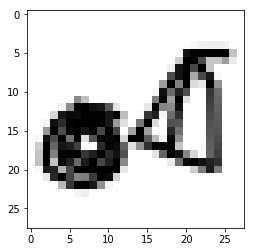

In [10]:
plt.imshow(X_test[-5].reshape(28, 28), cmap='Greys');

In [49]:
def draw_examples(X, Y, classes, rows=6, scale=1):
    fig, axs = plt.subplots(rows, len(classes), figsize=(scale * len(classes), scale * rows))
    size = X.shape[1]
    for class_id in range(len(classes)):
        X_class = X[Y == class_id]
        for i in range(rows):
            ax = axs[i, class_id]
            x = X_class[np.random.randint(len(classes))].reshape(size, size)
            ax.imshow(x, cmap='Greys', interpolation='none')
            ax.axis('off')

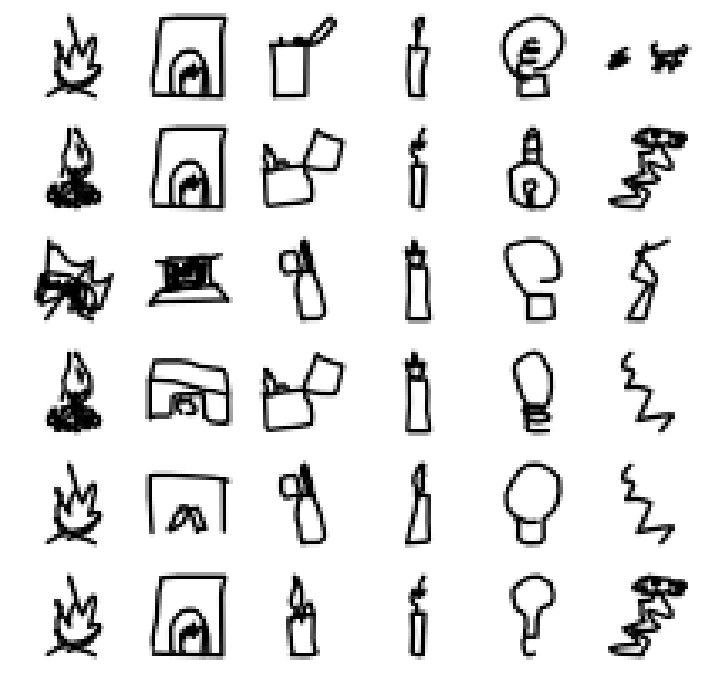

In [50]:
draw_examples(X_train, Y_train, classes, rows=6, scale=2)

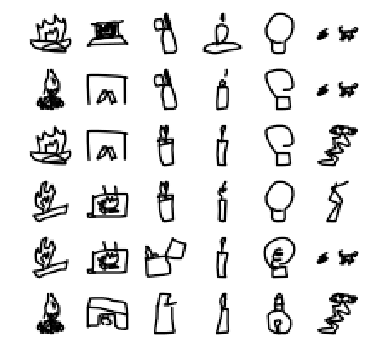

In [11]:
rows = 6
fig, axs = plt.subplots(rows, len(classes), figsize=(len(classes), rows))
for class_id in range(len(classes)):
    X_class = X_train[Y_train == class_id]
    for i in range(rows):
        ax = axs[i, class_id]
        x = X_class[np.random.randint(len(classes))].reshape(size, size)
        ax.imshow(x, cmap='Greys', interpolation='none')
        ax.axis('off')

## Averages


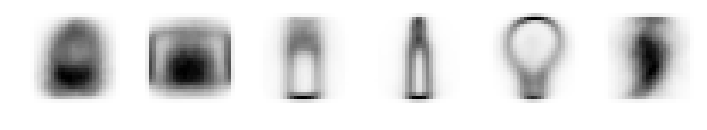

In [12]:
fig, axs = plt.subplots(1, len(classes), figsize=(2 * len(classes), 2))
for class_id in range(len(classes)):
    X_class = X_train[Y_train == class_id]
    ax = axs[class_id]
    x = X_class.mean(axis=0).reshape(size, size)
    ax.imshow(x, cmap='Greys', interpolation='none')
    ax.axis('off')

## Train a model

In [13]:
model = Sequential()

model.add(Conv2D(12, (5, 5), activation='relu',
                 input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(20, (5, 5), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       312     1.4%
                relu   #####     24   24   12
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   12
              Conv2D    \|/  -------------------      6020    26.5%
                relu   #####      8    8   20
             Dropout    | || -------------------         0     0.0%
                       #####      8    8   20
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   20
             Flatten   ||||| -------------------         0     0.0%
                       #####         320
               Dense   XXXXX -------------------     16050    70.7%
                relu   #####          50
               Dense   XXXXX -------------------       306     1.3%
             softmax   #

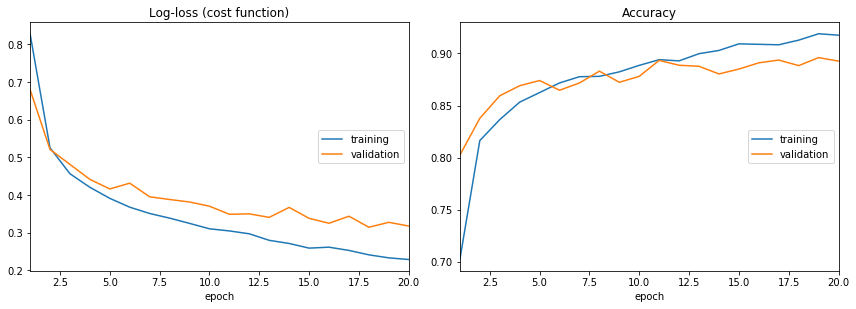

In [14]:
# training
model.fit(X_train, Y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()])

In [15]:
model.predict(X_test[:3])

array([[8.9317834e-01, 9.1939688e-02, 1.4649743e-03, 3.7041181e-03,
        8.6219721e-03, 1.0908891e-03],
       [7.9189384e-05, 3.6044556e-04, 9.7845728e-03, 9.8582876e-01,
        1.3119498e-03, 2.6349830e-03],
       [9.3883216e-01, 2.6612543e-02, 1.0435398e-03, 1.2621763e-02,
        1.9063992e-02, 1.8260150e-03]], dtype=float32)

## Let's see predictions

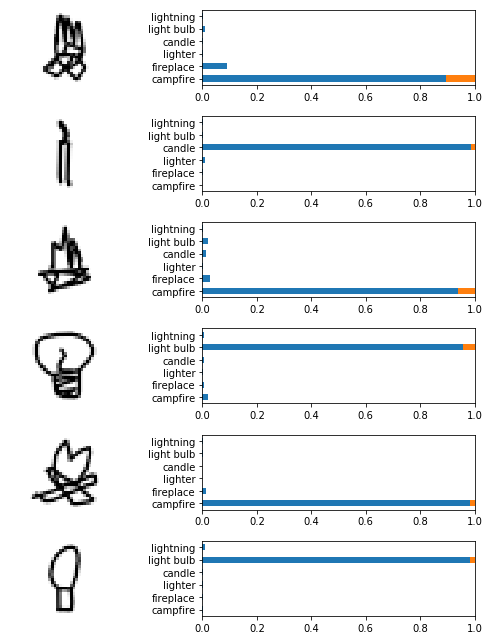

In [16]:
rows = 6
preds = model.predict(X_test[:rows])

fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
for i in range(rows):
    ax = axs[i, 0]
    ax.imshow(X_test[i].reshape(size, size),
          cmap='Greys', interpolation='none')

    ax.axis('off')

    #  pd.Series(preds[i], index=classes) \
    # .plot('barh', ax=axs[i, 1], xlim=[0, 1], title=classes[Y_test[i]])
    
    pd.DataFrame({"pred": preds[i], "true": [int(Y_test[i] == j) for j in range(len(classes))]}, index=classes) \
    .plot(kind='barh', ax=axs[i, 1], xlim=[0, 1], stacked=True, legend=False)
    

plt.tight_layout()

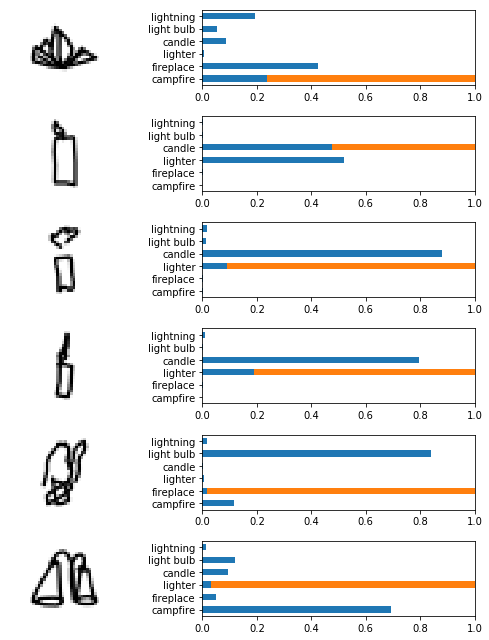

In [17]:
rows = 6
preds = model.predict(X_test)
incorrect = model.predict_classes(X_test) != Y_test

preds = preds[incorrect]
X_incorrect = X_test[incorrect]
Y_incorrect = Y_test[incorrect]


fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
for i in range(rows):
    ax = axs[i, 0]
    ax.imshow(X_incorrect[i].reshape(size, size),
          cmap='Greys', interpolation='none')

    ax.axis('off')

    #  pd.Series(preds[i], index=classes) \
    # .plot('barh', ax=axs[i, 1], xlim=[0, 1], title=classes[Y_test[i]])
    
    pd.DataFrame({"pred": preds[i], "true": [int(Y_incorrect[i] == j) for j in range(len(classes))]}, index=classes) \
    .plot(kind='barh', ax=axs[i, 1], xlim=[0, 1], stacked=True, legend=False)
    

plt.tight_layout()

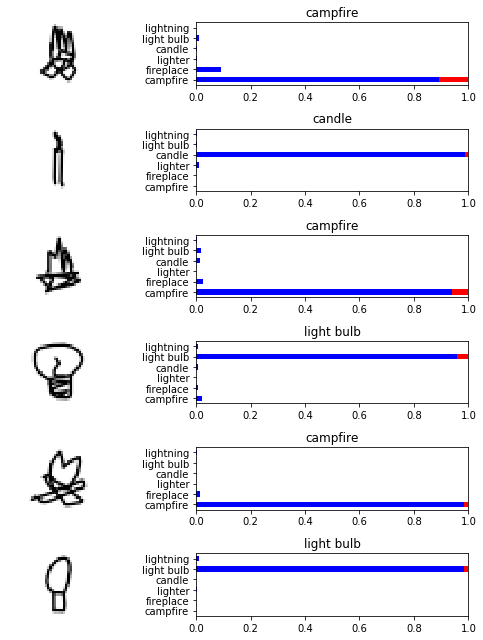

In [18]:
rows = 6
preds = model.predict(X_test[:rows])

fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
for i in range(rows):
    ax = axs[i, 0]
    ax.imshow(X_test[i].reshape(size, size),
          cmap='Greys', interpolation='none')

    ax.axis('off')

    pd.Series([int(Y_test[i] == j) for j in range(len(classes))], index=classes) \
      .plot('barh', ax=axs[i, 1], xlim=[0, 1], color='red')

    pd.Series(preds[i], index=classes) \
      .plot('barh', ax=axs[i, 1], xlim=[0, 1], color='blue')
    
    #pd.DataFrame({"pred": preds[i], "true": [int(Y_test[i] == j) for j in range(len(classes))]}, index=classes) \
    #.plot(kind='barh', ax=axs[i, 1], xlim=[0, 1], stacked=True, legend=False)
    

plt.tight_layout()

## OK 

In [19]:
def print_false_predictions(names, how_many):
    res = model(X_test).max(dim=1)[1]
    eq = (Y_test != res)
    good = Y_test[eq]
#class_names = ['airplane', 'onion', 'apple', 'pineapple', 'ant', 'banana', 'ambulance', 'angel']
    test_fail = X_test[eq] #Tylko złe wyniki
    predictions = F.softmax(model(test_fail), dim = 1)

    rows = how_many
    fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
    for i in range(rows):
        ax = axs[i,0]
        idx = np.random.randint(len(test_fail))
    
        ax.imshow(test_fail[idx,0].reshape(28,28),
              cmap='Greys', interpolation='none')
    
        ax.axis('off')
        
        pd.Series(predictions[idx].detach().numpy(), index=names) \
        .plot('barh', ax=axs[i,1], xlim=[0,1], title=names[good[idx]])
        
    plt.tight_layout()

## Quantify confusion

In [21]:
preds = model.predict_classes(X_test)
cm = confusion_matrix(Y_test, preds)
cm

array([[459,  16,   1,   0,   8,  14],
       [ 60, 430,   5,   6,   4,   8],
       [  6,   1, 445,  44,   9,  11],
       [  3,   4,  62, 395,   4,   6],
       [  6,   4,   1,   2, 466,  11],
       [  7,   1,   3,   2,  13, 483]])

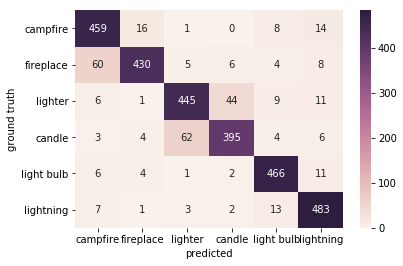

In [29]:
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_df.columns.name = "predicted"
cm_df.index.name = "ground truth"

sns.heatmap(cm_df, annot=True, fmt='d')

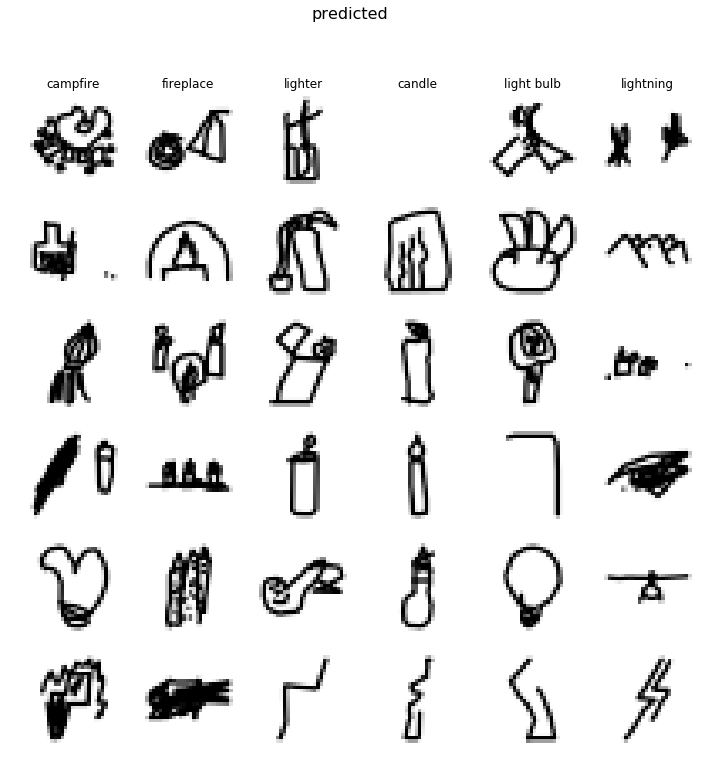

In [39]:
confused = np.zeros((len(classes), len(classes), size, size), dtype='float32')
Y_pred = model.predict_classes(X_test)
for x, y_true, y_pred in zip(X_test, Y_test, Y_pred):
    confused[y_true, y_pred] = x[:, :, 0]

fig, axs = plt.subplots(len(classes), len(classes), figsize=(2*len(classes), 2*len(classes)))
for i in range(len(classes)):
    for j in range(len(classes)):
        ax = axs[i, j]
        ax.imshow(confused[i, j], cmap='Greys', interpolation='none')
        ax.axis('off')
        
fig.suptitle('predicted', fontsize=16)
for ax, c in zip(axs[0], classes):
        ax.set_title(c)

## Thanks!

Follow me on Twitter [@pmigdal](https://twitter.com/pmigdal).

If you want to learn more, some relevant writing:

* [Learning Deep Learning with Keras](https://p.migdal.pl/2017/04/30/teaching-deep-learning.html)
* [Keras or PyTorch as your first deep learning framework](https://deepsense.ai/keras-or-pytorch/) (previously with an inflammatory title *Don't learn TensorFlow - start with Keras or PyTorch instead*)
* [Simple diagrams of convoluted neural networks](https://medium.com/inbrowserai/simple-diagrams-of-convoluted-neural-networks-39c097d2925b) - In Browser AI

## Ideas

* latent spaces
* go through slides: last Berlin, and sth for kids